## Libraries

In [2]:
import gensim
import pandas as pd
import spacy
import numpy as np
from wefe.word_embedding_model import WordEmbeddingModel
from scipy.stats import pearsonr
from wefe.metrics import RIPA
from wefe.query import Query
import re
from gensim.models import KeyedVectors
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import random


In [3]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s'
)


## Helper Functions

In [4]:
def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compute_bias(adj, male_terms, female_terms, model):
    male_mean = np.mean([cosine_similarity(model[adj], model[m]) for m in male_terms if m in model])
    female_mean = np.mean([cosine_similarity(model[adj], model[f]) for f in female_terms if f in model])
    return male_mean - female_mean

def compute_individual_bias(
    adjectives,
    male_terms,
    female_terms,
    model,
    exclude_substrings=True
):
    """
    Computes, for each adjective, the 'bias' difference between the average 
    cosine similarity with male terms and the average cosine similarity 
    with female terms.

    Parameters
    ----------
    adjectives : list of str
        List of adjectives to be analyzed (already cleaned/lemmatized).
    male_terms : list of str
        Words representing 'masculinity' (e.g., ['man', 'boy', 'father', ...]).
    female_terms : list of str
        Words representing 'femininity' (e.g., ['woman', 'girl', 'lady', ...]).
    model : dict-like of {str -> np.ndarray} or a KeyedVectors-like object
        Your embedding model, where you can check `word in model` and 
        retrieve vectors using `model[word]`.
    exclude_substrings : bool, default=True
        Whether to exclude adjectives that contain any of the male or female 
        terms as substrings (e.g., "manlike" contains "man").

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['word', 'male_mean', 'female_mean', 'bias_value'].
        Where 'bias_value' = male_mean - female_mean.
        Rows without sufficient embedding data are skipped.
    """

    # 1) filter out adjectives containing gender terms as substrings
    if exclude_substrings:
        all_target_words = set(male_terms + female_terms)
        def has_target_substring(adj):
            return any(tw in adj for tw in all_target_words)
        adjectives = [adj for adj in adjectives if not has_target_substring(adj)]

    records = []

    # 2) Loop over each adjective
    for adj in adjectives:
        if adj not in model:
            continue

        adj_vec = model[adj]

        # Gather cosine similarities with male terms
        male_sims = []
        for m in male_terms:
            if m in model:
                male_sims.append(cosine_similarity(adj_vec, model[m]))

        # Gather cosine similarities with female terms
        female_sims = []
        for f in female_terms:
            if f in model:
                female_sims.append(cosine_similarity(adj_vec, model[f]))

        # Skip if we can't compute both male and female means
        if len(male_sims) == 0 or len(female_sims) == 0:
            continue

        # Compute means
        male_mean = np.mean(male_sims)
        female_mean = np.mean(female_sims)

        # Compute bias
        bias_value = male_mean - female_mean

        records.append({
            "word": adj,
            "male_mean": male_mean,
            "female_mean": female_mean,
            "bias_value": bias_value
        })

    df_bias = pd.DataFrame(records)
    return df_bias

def compute_bias_with_pvalue(adj, male_terms, female_terms, model, permutations=1000, seed=42):
    """
    Computes the cosine-based gender bias of an adjective relative to male and female word sets,
    and estimates the statistical significance using a permutation test.

    Parameters
    ----------
    adj : str
        The adjective whose bias is being measured.

    male_terms : list of str
        A list of words representing the male group (e.g., ["man", "vader", "kerel"]).

    female_terms : list of str
        A list of words representing the female group (e.g., ["vrouw", "moeder", "meid"]).

    model : KeyedVectors or similar
        A word embedding model that supports word lookup and cosine operations (e.g., Word2Vec or FastText).

    permutations : int, default=1000
        The number of random shuffles to perform during the permutation test.

    seed : int, default=42
        Random seed to ensure reproducibility of the permutation results.

    Returns
    -------
    real_bias : float
        The observed bias score, defined as:
        mean_cosine(adj, male_terms) - mean_cosine(adj, female_terms)

    p_value : float
        The estimated probability that a bias of this magnitude (or stronger) could occur
        by chance if gender labels were random. Lower values indicate stronger significance.

    Description
    -----------
    - Step 1: Compute the real (observed) bias of the adjective using cosine similarity.
    - Step 2: Create a combined pool of male and female terms.
    - Step 3: Run `permutations` number of times:
        - Shuffle the gender labels randomly.
        - Split into fake "male" and "female" groups.
        - Compute the permuted bias score.
        - Count how many times the permuted score is greater than or equal to the real bias.
    - Step 4: The p-value is the proportion of permutations that produced a more extreme bias
              than the observed one.
    """

    # Ensure reproducibility
    np.random.seed(seed)

    # Step 1: Compute the real cosine-based bias score
    real_bias = compute_bias(adj, male_terms, female_terms, model)

    # Combine all gender terms into one pool to shuffle
    combined_terms = male_terms + female_terms
    num_male = len(male_terms)

    # Counter for how many permuted scores are as extreme as the real one
    extreme_count = 0

    # Step 2: Permutation loop
    for _ in range(permutations):
        np.random.shuffle(combined_terms)

        # Split shuffled terms into permuted male and female groups
        permuted_male = combined_terms[:num_male]
        permuted_female = combined_terms[num_male:]

        # Step 3: Compute bias under this random split
        permuted_bias = compute_bias(adj, permuted_male, permuted_female, model)

        # Count if the permuted bias is more extreme than the observed one
        if abs(permuted_bias) >= abs(real_bias):
            extreme_count += 1

    # Step 4: Compute the p-value as the proportion of extreme permutations
    p_value = extreme_count / permutations

    return real_bias, p_value

def tag_bias_agreement(row, alpha=0.05):
    sig_w2v = row['p_value_w2v'] < alpha
    sig_ft  = row['p_value_ft'] < alpha
    same_sign = np.sign(row['bias_w2v']) == np.sign(row['bias_ft'])

    if sig_w2v and sig_ft:
        if same_sign:
            return "Significant in both (agree)"
        else:
            return "Significant in both (oppose)"
    elif sig_w2v:
        return "Only Word2Vec"
    elif sig_ft:
        return "Only FastText"
    else:
        return "Non-significant"

## Embedding Models

In [5]:
###############################################################################
# 1) Load FastText embeddings
###############################################################################
logging.info("Loading Fasttext embeddings with Gensim from file...")
nl_embeddings = gensim.models.KeyedVectors.load_word2vec_format(
    "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz", 
    binary=False
)
logging.info("Fasttext embeddings loaded.")

# Convert to WEFE-compatible format
fasttext_model = WordEmbeddingModel(nl_embeddings, "Dutch FastText")
logging.info("Fasttext Embeddings Model Created.")

###############################################################################
# 2) Load Word2Vec model
###############################################################################
logging.info("Loading Word2Vec model from file...")
model_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/sonar-320.txt"
model_w2v = KeyedVectors.load_word2vec_format(model_path, binary=False)
logging.info("Word2Vec Model loaded successfully.")

2025-04-24 12:37:53,198 [INFO] Loading Fasttext embeddings with Gensim from file...
2025-04-24 12:37:53,199 [INFO] loading projection weights from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz
2025-04-24 12:40:37,249 [INFO] KeyedVectors lifecycle event {'msg': 'loaded (2000000, 300) matrix of type float32 from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-04-24T12:40:37.248991', 'gensim': '4.3.3', 'python': '3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'load_word2vec_format'}
2025-04-24 12:40:37,249 [INFO] Fasttext embeddings loaded.
2025-04-24 12:40:37,249 [INFO] Fasttext Embeddings Model Created.
2025-04-24 12:40:37,249 [INFO] Loading Word2Vec model from file...
2025-04-24 12:40:37,250 [INFO] loading projection weights

## Extracting Adjectives + Spacy 

In [6]:
NUMERIC_WORDS = {
    "twee", "drie", "vier", "vijf", "zes", "zeven", "acht", "negen", "tien",
    "elf", "twaalf", "dertien", "veertien", "vijftien", "zestien", "zeventien",
    "achttien", "negentien", "twintig", "dertig", "veertig", "vijftig",
    "zestig", "zeventig", "tachtig", "negentig", "honderd", "duizend"
}


In [7]:
###############################################################################
# 3) Load spaCy for Dutch, define function to extract adjectives
###############################################################################
nlp = spacy.load('nl_core_news_lg')

def contains_numeric_word(lemma):
    return any(num in lemma for num in NUMERIC_WORDS)

def extract_adjectives_from_csv(file_path):
    """
    Leest een CSV-bestand in, parse elke phrase met spaCy,
    en retourneert unieke gelemmatiseerde bijvoeglijke naamwoorden.
    """
    logging.info(f"Loading CSV file: {file_path}")
    try:
        df = pd.read_csv(file_path, delimiter=';', usecols=[0], names=["Group"], header=0)
        logging.info(f"CSV loaded successfully with shape: {df.shape}")
    except Exception as e:
        logging.error(f"Failed to load CSV file: {e}")
        raise

    df.dropna(subset=["Group"], inplace=True)
    logging.info(f"Dropped NaN rows. Remaining phrases: {len(df)}")

    adjectives = []
    logging.info("Starting POS tagging and lemmatization...")
    for idx, phrase in enumerate(df["Group"]):
        doc = nlp(phrase)
        for token in doc:
            if token.pos_ == "ADJ" and token.is_alpha:
                lemma = token.lemma_.lower()

                # Filter alles met tekstuele getallen behalve 'een'
                if lemma != "een" and contains_numeric_word(lemma):
                    continue
                adjectives.append(lemma)

        if idx % 1000 == 0 and idx > 0:
            logging.info(f"Processed {idx} phrases...")

    unique_adjectives = list(dict.fromkeys(adjectives))
    logging.info(f"Extracted {len(unique_adjectives)} unique adjectives.")
    return unique_adjectives

# ---- Use the function ----
csv_file_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv"
adjectives = extract_adjectives_from_csv(csv_file_path)
                                         ###############################################################################
# 3) Load spaCy for Dutch, define function to extract adjectives
###############################################################################
nlp = spacy.load('nl_core_news_lg')

def contains_numeric_word(lemma):
    return any(num in lemma for num in NUMERIC_WORDS)

def extract_adjectives_from_csv(file_path):
    """
    Leest een CSV-bestand in, parse elke phrase met spaCy,
    en retourneert unieke gelemmatiseerde bijvoeglijke naamwoorden.
    """
    logging.info(f"Loading CSV file: {file_path}")
    try:
        df = pd.read_csv(file_path, delimiter=';', usecols=[0], names=["Group"], header=0)
        logging.info(f"CSV loaded successfully with shape: {df.shape}")
    except Exception as e:
        logging.error(f"Failed to load CSV file: {e}")
        raise

    df.dropna(subset=["Group"], inplace=True)
    logging.info(f"Dropped NaN rows. Remaining phrases: {len(df)}")

    adjectives = []
    logging.info("Starting POS tagging and lemmatization...")
    for idx, phrase in enumerate(df["Group"]):
        doc = nlp(phrase)
        for token in doc:
            if token.pos_ == "ADJ" and token.is_alpha:
                lemma = token.lemma_.lower()

                # Filter alles met tekstuele getallen behalve 'een'
                if lemma != "een" and contains_numeric_word(lemma):
                    continue
                adjectives.append(lemma)

        if idx % 1000 == 0 and idx > 0:
            logging.info(f"Processed {idx} phrases...")

    unique_adjectives = list(dict.fromkeys(adjectives))
    logging.info(f"Extracted {len(unique_adjectives)} unique adjectives.")
    return unique_adjectives

# ---- Use the function ----
csv_file_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv"
adjectives = extract_adjectives_from_csv(csv_file_path)

2025-04-24 12:41:36,114 [INFO] Loading CSV file: /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv
2025-04-24 12:41:36,148 [INFO] CSV loaded successfully with shape: (19242, 1)
2025-04-24 12:41:36,153 [INFO] Dropped NaN rows. Remaining phrases: 19239
2025-04-24 12:41:36,153 [INFO] Starting POS tagging and lemmatization...
2025-04-24 12:41:37,701 [INFO] Processed 1000 phrases...
2025-04-24 12:41:39,329 [INFO] Processed 2000 phrases...
2025-04-24 12:41:40,854 [INFO] Processed 3000 phrases...
2025-04-24 12:41:42,500 [INFO] Processed 4000 phrases...
2025-04-24 12:41:44,551 [INFO] Processed 5000 phrases...
2025-04-24 12:41:46,342 [INFO] Processed 6000 phrases...
2025-04-24 12:41:48,201 [INFO] Processed 7000 phrases...
2025-04-24 12:41:49,916 [INFO] Processed 8000 phrases...
2025-04-24 12:41:51,555 [INFO] Processed 9000 phrases...
2025-04-24 12:41:53,196 [INFO] Processed 10000 phrases...
2025-04-24 12:41:54,856 

In [8]:
adjectives_w2v = {w for w in adjectives if w in model_w2v}
adjectives_ft  = {w for w in adjectives if w in fasttext_model}


#  Take the intersection of the two sets
union_vocab = adjectives_w2v.intersection(adjectives_ft)
print(f"Number of adjectives in Word2Vec: {len(adjectives_w2v)}")
print(f"Number of adjectives in FastText : {len(adjectives_ft)}")
print(f"Total in intersection (Word2Vec ∪ FastText): {len(union_vocab)}")


# Exclude 'target_words' from the intersection
target_words = [
    "man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer",
    "opa", "oom", "vrouw", "dame", "meisje", "moeder", "dochter", 
    "tante", "oma", "mevrouw", "meid",
]

filtered_adjectives = [
    adj for adj in union_vocab
    if not any(tw in adj for tw in target_words)
]
print(f"Remaining adjectives in the intersection after filtering target words: {len(filtered_adjectives)}")

Number of adjectives in Word2Vec: 2675
Number of adjectives in FastText : 2685
Total in intersection (Word2Vec ∪ FastText): 2663
Remaining adjectives in the intersection after filtering target words: 2641


## Cosine Similarity Bias

In [9]:
# Define your reference sets (as in your message)
MALE_WORDS = ["man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom"]
FEMALE_WORDS = ["vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid"]

In [10]:
# STEP 1 — WORD2VEC
logging.info("Step 1 (W2V): Computing raw cosine biases for all adjectives...")

df_indiv_bias_w2v = compute_individual_bias(
    adjectives=filtered_adjectives,
    male_terms=MALE_WORDS,
    female_terms=FEMALE_WORDS,
    model=model_w2v,
    exclude_substrings=True  # Optional, avoids words like "mannetje"
)

logging.info(f"Word2Vec: Computed raw bias for {len(df_indiv_bias_w2v)} adjectives.")


# STEP 1 — FASTTEXT
logging.info("Step 1 (FastText): Computing raw cosine biases for all adjectives...")

df_indiv_bias_ft = compute_individual_bias(
    adjectives=filtered_adjectives,
    male_terms=MALE_WORDS,
    female_terms=FEMALE_WORDS,
    model=fasttext_model,
    exclude_substrings=True
)

logging.info(f"FastText: Computed raw bias for {len(df_indiv_bias_ft)} adjectives.")


2025-04-24 12:42:44,062 [INFO] Step 1 (W2V): Computing raw cosine biases for all adjectives...
2025-04-24 12:42:44,266 [INFO] Word2Vec: Computed raw bias for 2641 adjectives.
2025-04-24 12:42:44,267 [INFO] Step 1 (FastText): Computing raw cosine biases for all adjectives...
2025-04-24 12:42:44,468 [INFO] FastText: Computed raw bias for 2641 adjectives.


In [11]:
# STEP 2 — WORD2VEC
df_indiv_bias_w2v['abs_bias'] = df_indiv_bias_w2v['bias_value'].abs()
top_bias_words_w2v = df_indiv_bias_w2v.sort_values('abs_bias', ascending=False)['word'].tolist()

# STEP 2 — FASTTEXT
df_indiv_bias_ft['abs_bias'] = df_indiv_bias_ft['bias_value'].abs()
top_bias_words_ft = df_indiv_bias_ft.sort_values('abs_bias', ascending=False)['word'].tolist()

logging.info(f"most biased words (W2V):")
print(top_bias_words_w2v[:10])
logging.info(f"Most biased words (FastText):")
print(top_bias_words_ft[:10])


2025-04-24 12:42:44,475 [INFO] most biased words (W2V):
2025-04-24 12:42:44,476 [INFO] Most biased words (FastText):


['lesbisch', 'blond', 'beeldschoon', 'zwanger', 'ongepland', 'bloedmooie', 'beeldig', 'ongehuwd', 'kinderloos', 'sensueel']
['snoezig', 'beeldschoon', 'zwanger', 'mollig', 'tuttig', 'sensueel', 'genitaal', 'feminien', 'lieftallig', 'superschattig']


In [12]:
# STEP 3 — WORD2VEC
logging.info(f"Step 3 (W2V): Running permutation p-value test on adjectives...")
results_w2v = []

for word in filtered_adjectives:
    try:
        bias, pval = compute_bias_with_pvalue(word, MALE_WORDS, FEMALE_WORDS, model_w2v)
        results_w2v.append({'word': word, 'bias': bias, 'p_value': pval})
    except Exception as e:
        logging.warning(f"Word2Vec error on '{word}': {e}")

df_bias_sig_w2v = pd.DataFrame(results_w2v).sort_values('p_value')
logging.info(f"Word2Vec: Finished permutation testing for {len(results_w2v)} words.")
print("\n=== Top Word2Vec Results (sorted by p-value) ===")
print(df_bias_sig_w2v.head(10))


# STEP 3 — FASTTEXT
logging.info(f"Step 3 (FastText): Running permutation p-value test on adjectives...")
results_ft = []

for word in filtered_adjectives:
    try:
        bias, pval = compute_bias_with_pvalue(word, MALE_WORDS, FEMALE_WORDS, fasttext_model)
        results_ft.append({'word': word, 'bias': bias, 'p_value': pval})
    except Exception as e:
        logging.warning(f"⚠️ FastText error on '{word}': {e}")

df_bias_sig_ft = pd.DataFrame(results_ft).sort_values('p_value')
logging.info(f"FastText: Finished permutation testing for {len(results_ft)} words.")
print("\n=== Top FastText Results (sorted by p-value) ===")
print(df_bias_sig_ft.head(10))


2025-04-24 12:42:44,481 [INFO] Step 3 (W2V): Running permutation p-value test on adjectives...
2025-04-24 12:46:06,624 [INFO] Word2Vec: Finished permutation testing for 2641 words.
2025-04-24 12:46:06,628 [INFO] Step 3 (FastText): Running permutation p-value test on adjectives...



=== Top Word2Vec Results (sorted by p-value) ===
                 word      bias  p_value
1431            knapp -0.057418    0.001
1333        statutair  0.046310    0.002
2321  maatschappelijk -0.042173    0.003
180           indisch -0.042601    0.003
939      alleenstaand -0.047796    0.006
1847         lesbisch -0.081243    0.006
1878           luther  0.058629    0.006
1078            lamme  0.040604    0.006
972             zedig -0.046326    0.007
124           corrupt  0.062605    0.008


2025-04-24 12:49:25,279 [INFO] FastText: Finished permutation testing for 2641 words.



=== Top FastText Results (sorted by p-value) ===
                  word      bias  p_value
2306           geniaal  0.082225      0.0
2415       interessant  0.054448      0.0
24              zoetig -0.045422      0.0
1751         sceptisch  0.052741      0.0
1085       spijkerhard  0.085905      0.0
1666          feminien -0.094300      0.0
755   voetbaltechnisch  0.062676      0.0
142           lieflijk -0.074286      0.0
2139          poezelig -0.083723      0.0
807            slimmer  0.060725      0.0


### Metrics

In [1]:
# Merge on word
df_compare = pd.merge(
    df_bias_sig_w2v.rename(columns={'bias': 'bias_w2v', 'p_value': 'p_value_w2v'}),
    df_bias_sig_ft.rename(columns={'bias': 'bias_ft', 'p_value': 'p_value_ft'}),
    on='word',
    suffixes=('', '_ft')
)

# Tag each row (assuming tag_bias_agreement function is defined elsewhere)
df_compare['tag'] = df_compare.apply(tag_bias_agreement, axis=1)

# Set publication-quality parameters
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8

# Create figure with appropriate dimensions for academic paper
plt.figure(figsize=(10, 8), dpi=300)

# Professional color palette (colorblind-friendly)
palette = {
    "Significant in both (agree)": "#4E79A7",    # blue
    "Significant in both (oppose)": "##E15759",   # orange
    "Only Word2Vec": "#3A923A",                  # green
    "Only FastText": "#C03D3E",                  # red
    "Non-significant": "#999999"                 # gray
}

# Create the scatterplot with professional styling
scatter = sns.scatterplot(
    data=df_compare,
    x='bias_w2v',
    y='bias_ft',
    hue='tag',
    palette=palette,
    s=60,  # Slightly smaller points for clarity
    edgecolor='white',  # White edges help distinguish overlapping points
    alpha=0.8,
    linewidth=0.5
)

# Add reference lines with improved styling
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.6)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.6)
plt.plot([-0.15, 0.15], [-0.15, 0.15], linestyle=':', color='dimgray', linewidth=0.8, alpha=0.7)  # y = x

# Quadrant labels with better positioning and formatting
quadrant_labels = [
    {"text": "Consistent\nMale Bias", "pos": (0.08, 0.12), "ha": "center", "fontweight": "bold"},
    {"text": "Contradictory Bias\n(FastText → Male\nWord2Vec → Female)", "pos": (-0.1, 0.1), "ha": "center", "fontweight": "normal"},
    {"text": "Consistent\nFemale Bias", "pos": (-0.1, -0.1), "ha": "center", "fontweight": "bold"},
]

for label in quadrant_labels:
    text = plt.text(
        label["pos"][0], label["pos"][1], 
        label["text"], 
        fontsize=10, 
        color='dimgray',
        ha=label["ha"],
        va="center",
        fontweight=label.get("fontweight", "normal"),
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2)
    )
    # Add subtle shadow effect for better readability
    text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])



# Axis labels with more professional formatting
plt.xlabel("Gender Bias Score (Word2Vec)", 
           fontsize=12, labelpad=10)
plt.ylabel("Gender Bias Score (FastText)", 
           fontsize=12, labelpad=10)


# Legend with better formatting and positioning
handles, labels = plt.gca().get_legend_handles_labels()
order = [
    "Significant in both (agree)",
    "Significant in both (oppose)",
    "Only Word2Vec",
    "Only FastText",
    "Non-significant"
]
ordered = sorted(zip(labels, handles), key=lambda x: order.index(x[0]))
labels, handles = zip(*ordered)

legend = plt.legend(
    handles, labels,
    title="Bias Significance Category",
    loc='lower right',
    fontsize=10,
    title_fontsize=11,
    frameon=True,
    framealpha=0.95,
    edgecolor='lightgray'
)
legend.get_frame().set_linewidth(0.8)

# Set consistent axis limits
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)

# Add subtle grid for readability
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Make tick marks more readable
plt.tick_params(axis='both', which='major', labelsize=10, width=0.8, length=4)

# Add subtle axes spines
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.8)
    spine.set_color('gray')

# Improve overall layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save high-resolution figure for publication
plt.savefig('gender_bias_agreement_plot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gender_bias_agreement_plot.png', bbox_inches='tight', dpi=300)

# Display the figure
plt.show()

NameError: name 'pd' is not defined

In [14]:
corr, pval = pearsonr(df_compare['bias_w2v'], df_compare['bias_ft'])
print(f"Correlation (Word2Vec vs. FastText) = {corr:.3f} (p = {pval:.4g})")

Correlation (Word2Vec vs. FastText) = 0.557 (p = 2.714e-215)


### Z-scores

In [15]:
# STEP 1 — Z-scores for Word2Vec
mean_w2v = df_bias_sig_w2v['bias'].mean()
std_w2v = df_bias_sig_w2v['bias'].std()

df_bias_sig_w2v['z_score_w2v'] = (df_bias_sig_w2v['bias'] - mean_w2v) / std_w2v

# STEP 1 — Z-scores for FastText
mean_ft = df_bias_sig_ft['bias'].mean()
std_ft = df_bias_sig_ft['bias'].std()

df_bias_sig_ft['z_score_ft'] = (df_bias_sig_ft['bias'] - mean_ft) / std_ft


In [16]:
# Merge on shared adjectives
df_z_compare = pd.merge(
    df_bias_sig_w2v[['word', 'z_score_w2v']],
    df_bias_sig_ft[['word', 'z_score_ft']],
    on='word'
)

# Select top N based on absolute average Z-score
df_z_compare['avg_abs_z'] = (df_z_compare['z_score_w2v'].abs() + df_z_compare['z_score_ft'].abs()) / 2
df_top = df_z_compare.sort_values('avg_abs_z', ascending=False).head(30)

print("\n=== Top 30 Biased Words Across Both Models (by average Z) ===")
print(df_top[['word', 'z_score_w2v', 'z_score_ft']])


=== Top 30 Biased Words Across Both Models (by average Z) ===
              word  z_score_w2v  z_score_ft
117    beeldschoon    -3.722530   -4.195354
80         zwanger    -3.684167   -4.190968
5         lesbisch    -4.045882   -3.515283
46        sensueel    -3.233835   -4.003994
89          tuttig    -3.000134   -4.085640
23        bevallig    -3.061357   -3.620957
26      bloedmooie    -3.362361   -3.208645
19           blond    -3.860200   -2.684552
11         beeldig    -3.333266   -3.171831
18    feministisch    -3.103223   -3.399234
153         mollig    -2.249227   -4.171565
331     lieftallig    -2.175136   -3.785378
8            zedig    -2.265749   -3.672614
76      goudblonde    -2.739430   -3.133878
39      glamoureus    -2.717603   -3.117920
135      roodharig    -2.655877   -3.163479
685       genitaal    -1.911649   -3.855304
92        erotisch    -2.684212   -2.984080
27        vaginaal    -2.811783   -2.840383
57     donkerharig    -2.976514   -2.650481
187     volup

In [17]:
# Filter separately
df_male = df_z_compare[
    (df_z_compare['z_score_w2v'] > 0) & (df_z_compare['z_score_ft'] > 0)
].copy()

df_female = df_z_compare[
    (df_z_compare['z_score_w2v'] < 0) & (df_z_compare['z_score_ft'] < 0)
].copy()

# top-N limit
TOP_N = 10
df_male = df_male.sort_values('avg_abs_z', ascending=False).head(TOP_N)
df_female = df_female.sort_values('avg_abs_z', ascending=False).head(TOP_N)

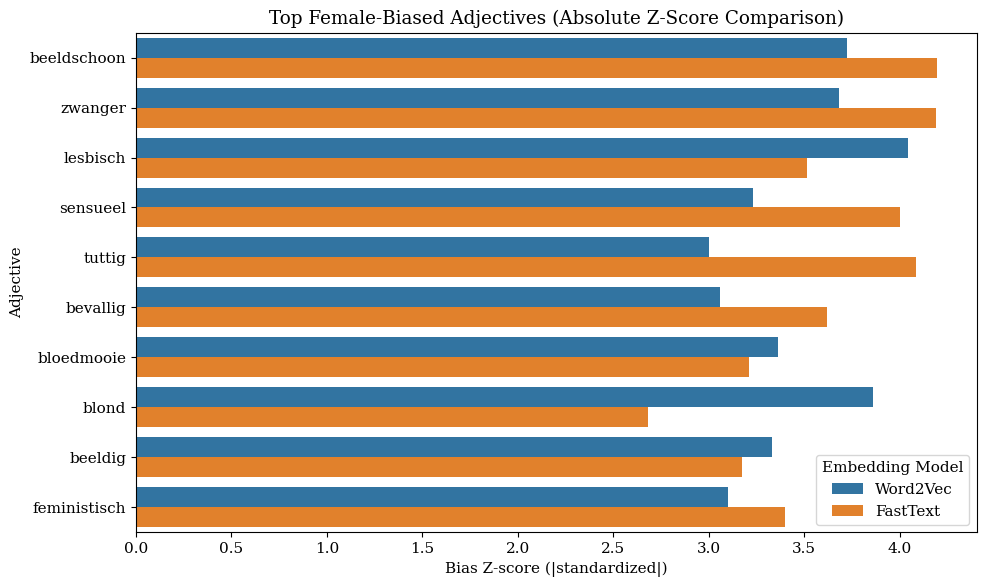

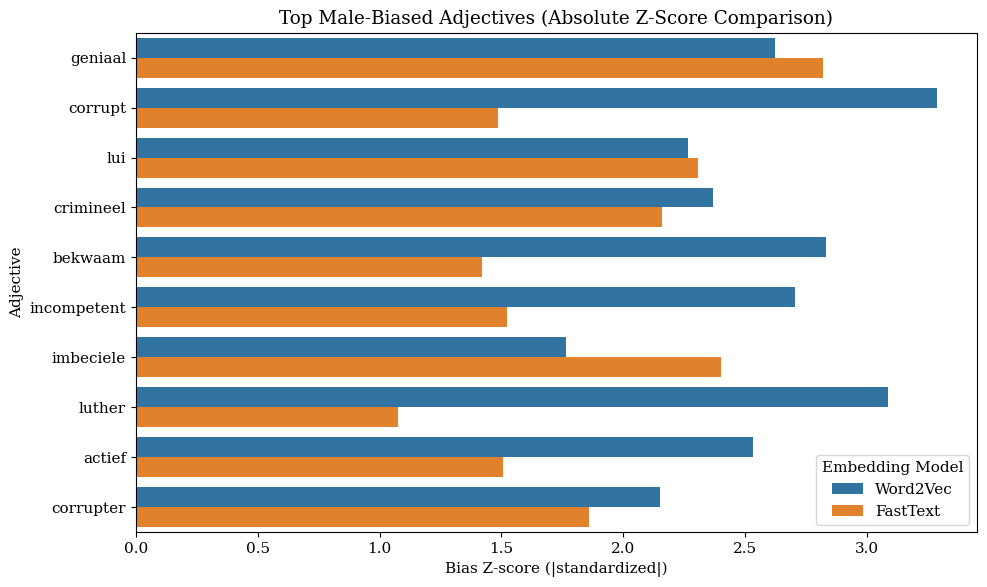

In [18]:
def plot_bias_barplot_abs(df_subset, title):
    """
    Plot absolute Z-scores for bias (e.g., for female-biased words),
    so all bars go left to right.
    """
    df_plot = df_subset.copy()

    # Take absolute Z-scores
    df_plot['z_score_w2v'] = df_plot['z_score_w2v'].abs()
    df_plot['z_score_ft'] = df_plot['z_score_ft'].abs()

    # Sort by average
    df_plot['avg_z'] = (df_plot['z_score_w2v'] + df_plot['z_score_ft']) / 2
    df_plot = df_plot.sort_values('avg_z', ascending=False)

    df_melted = df_plot.melt(
        id_vars='word',
        value_vars=['z_score_w2v', 'z_score_ft'],
        var_name='Model',
        value_name='Z-score'
    )
    df_melted['Model'] = df_melted['Model'].map({
        'z_score_w2v': 'Word2Vec',
        'z_score_ft': 'FastText'
    })
    df_melted['word'] = pd.Categorical(df_melted['word'], categories=df_plot['word'], ordered=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_melted,
        y='word',
        x='Z-score',
        hue='Model',
        orient='h'
    )
    plt.title(title)
    plt.xlabel("Bias Z-score (|standardized|)")
    plt.ylabel("Adjective")
    plt.legend(title="Embedding Model", loc='lower right')
    plt.tight_layout()
    plt.show()

# Call the updated function for female-biased words
plot_bias_barplot_abs(df_female, "Top Female-Biased Adjectives (Absolute Z-Score Comparison)")
plot_bias_barplot_abs(df_male, "Top Male-Biased Adjectives (Absolute Z-Score Comparison)")


## RIPA

In [19]:
class GensimDutchEmbeddingModel(WordEmbeddingModel):
    def __init__(self, keyed_vectors):
        super().__init__(wv=keyed_vectors)
w2v_model = GensimDutchEmbeddingModel(model_w2v)


In [20]:
# Define the query
query = Query(
    target_sets=[
        ["man", "kerel", "jongen", "vader", "zoon", "vent", "meneer", "opa", "oom"],
        ["vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid"]],
    attribute_sets=[adjectives], 
    target_sets_names=["Male Terms", "Female Terms"],
    attribute_sets_names=["Adjectives"],
)

ripa = RIPA()
result_ripa_w2v = ripa.run_query(query, w2v_model)
result_ripa_ft = ripa.run_query(query, fasttext_model)

In [21]:
# 'result["word_values"]' {woord: {'mean': x, 'std': y}, ...}
df_ripa_w2v = pd.DataFrame({
    'Word': result_ripa_w2v["word_values"].keys(),
    'Mean Score': [val['mean'] for val in result_ripa_w2v["word_values"].values()],
    'Std Dev': [val['std'] for val in result_ripa_w2v["word_values"].values()],
})

search_words = ["sterk", "zacht", "moedig", "emotioneel", "dominant", 
                "zorgzaam", "aardig", "knap", "schattig"]

# Sorteer op Mean Score (die RIPA per woord toekent) en bekijk
df_ripa_w2v = df_ripa_w2v.sort_values(by="Mean Score", ascending=False).reset_index(drop=True)

df_ripa_ft = pd.DataFrame({
    'Word': result_ripa_ft["word_values"].keys(),
    'Mean Score': [val['mean'] for val in result_ripa_ft["word_values"].values()],
    'Std Dev': [val['std'] for val in result_ripa_ft["word_values"].values()],
})


# Sorteer op Mean Score (die RIPA per woord toekent) en bekijk
df_ripa_w2v = df_ripa_w2v.sort_values(by="Mean Score", ascending=False).reset_index(drop=True)
df_ripa_ft = df_ripa_ft.sort_values(by="Mean Score", ascending=False).reset_index(drop=True)

In [22]:
# Z-score
mean_of_scores_w2v = df_ripa_w2v["Mean Score"].mean()
std_of_scores_w2v = df_ripa_w2v["Mean Score"].std()
df_ripa_w2v["Z-Score"] = (df_ripa_w2v["Mean Score"] - mean_of_scores_w2v) / std_of_scores_w2v
df_ripa_w2v = df_ripa_w2v.sort_values("Z-Score", ascending=False).reset_index(drop=True)


mean_of_scores_ft = df_ripa_ft["Mean Score"].mean()
std_of_scores_ft = df_ripa_ft["Mean Score"].std()
df_ripa_ft["Z-Score"] = (df_ripa_ft["Mean Score"] - mean_of_scores_ft) / std_of_scores_ft
df_ripa_ft = df_ripa_ft.sort_values("Z-Score", ascending=False).reset_index(drop=True)


In [23]:
def prepare_bias_comparison(df_cosine, df_ripa):
    """
    Merge cosine similarity bias with RIPA scores, compute Z-scores, and return full merged DataFrame.
    """
    df = pd.merge(
        df_cosine,
        df_ripa[['Word', 'Mean Score']],
        left_on='word',
        right_on='Word',
        how='inner'
    ).rename(columns={'Mean Score': 'RIPA_score'})

    # Z-score normalize both metrics
    df['cosine_bias_z'] = (df['bias'] - df['bias'].mean()) / df['bias'].std()
    df['ripa_z'] = (df['RIPA_score'] - df['RIPA_score'].mean()) / df['RIPA_score'].std()

    return df.drop(columns='Word')
# Assume you have:
# - df_bias_pval_w2v
# - df_ripa_w2v
# - df_bias_pval_ft
# - df_ripa_ft

df_combined_w2v = prepare_bias_comparison(df_bias_sig_w2v, df_ripa_w2v)
df_combined_ft  = prepare_bias_comparison(df_bias_sig_ft, df_ripa_ft)


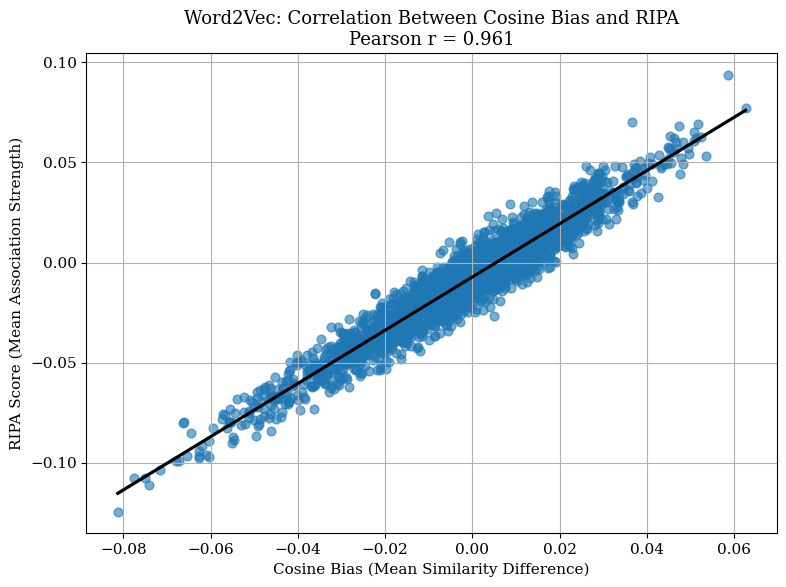

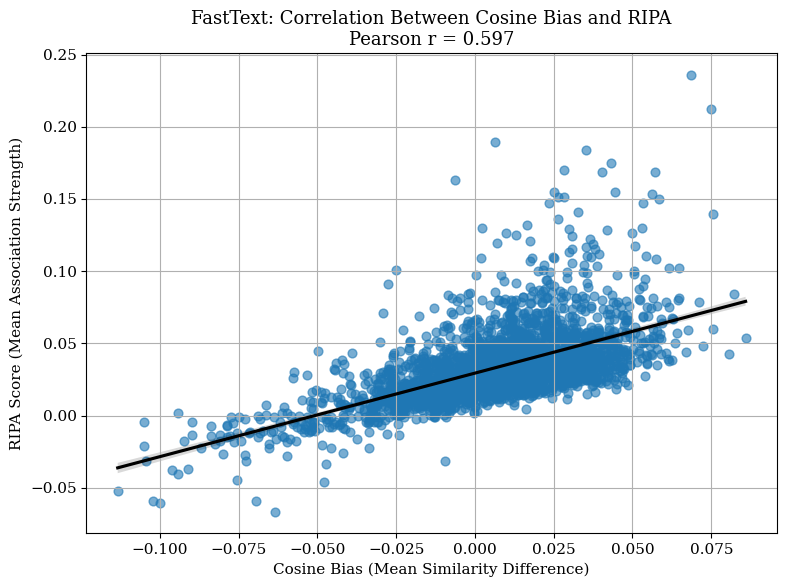

In [24]:
import scipy.stats as stats
def plot_bias_correlation(df, model_name):
    corr, p_val = stats.pearsonr(df['bias'], df['RIPA_score'])

    plt.figure(figsize=(8, 6))
    sns.regplot(
        x='bias',
        y='RIPA_score',
        data=df,
        scatter_kws={'alpha': 0.6, 's': 40},
        line_kws={'color': 'black'}
    )
    plt.title(
        f"{model_name}: Correlation Between Cosine Bias and RIPA\n"
        f"Pearson r = {corr:.3f}",
        fontsize=13
    )
    plt.xlabel("Cosine Bias (Mean Similarity Difference)", fontsize=11)
    plt.ylabel("RIPA Score (Mean Association Strength)", fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_bias_correlation(df_combined_w2v, "Word2Vec")
plot_bias_correlation(df_combined_ft, "FastText")


In [25]:
from scipy.stats import pearsonr
import pandas as pd

# Calculate correlations
r_w2v, p_w2v = pearsonr(df_combined_w2v['bias'], df_combined_w2v['RIPA_score'])
r_ft, p_ft   = pearsonr(df_combined_ft['bias'], df_combined_ft['RIPA_score'])

summary = pd.DataFrame({
    'Model': ['Word2Vec', 'FastText'],
    'r (Pearson)': [round(r_w2v, 3), round(r_ft, 3)],
    'N (words)': [len(df_combined_w2v), len(df_combined_ft)]
})

summary

,Model,r (Pearson),N (words)
0,Word2Vec,0.961,2641
1,FastText,0.597,2641


In [26]:
# Consistent (low diff) vs inconsistent (high diff)
df_combined_w2v['abs_diff'] = abs(df_combined_w2v['cosine_bias_z'] - df_combined_w2v['ripa_z'])
df_combined_ft['abs_diff']  = abs(df_combined_ft['cosine_bias_z'] - df_combined_ft['ripa_z'])

print("\n--- Top 5 Most Consistent (W2V) ---")
print(df_combined_w2v.sort_values('abs_diff').head(5)[['word', 'cosine_bias_z', 'ripa_z']])

print("\n--- Top 5 Most Divergent (W2V) ---")
print(df_combined_w2v.sort_values('abs_diff', ascending=False).head(5)[['word', 'cosine_bias_z', 'ripa_z']])



--- Top 5 Most Consistent (W2V) ---
              word  cosine_bias_z    ripa_z
1809      studieus       0.437570  0.437422
577      eenzijdig      -0.573615 -0.573202
18    feministisch      -3.103223 -3.103759
83       bruikbaar       1.610075  1.610624
2353  afzichtelijk       0.274938  0.274263

--- Top 5 Most Divergent (W2V) ---
                word  cosine_bias_z    ripa_z
1104            dood       1.958014  2.948445
2260           toffe       0.348041 -0.634290
2336    uiteindelijk       0.275752  1.222633
1946  overeenkomstig      -0.171883  0.741151
2232     geestelijke       0.367558  1.273814


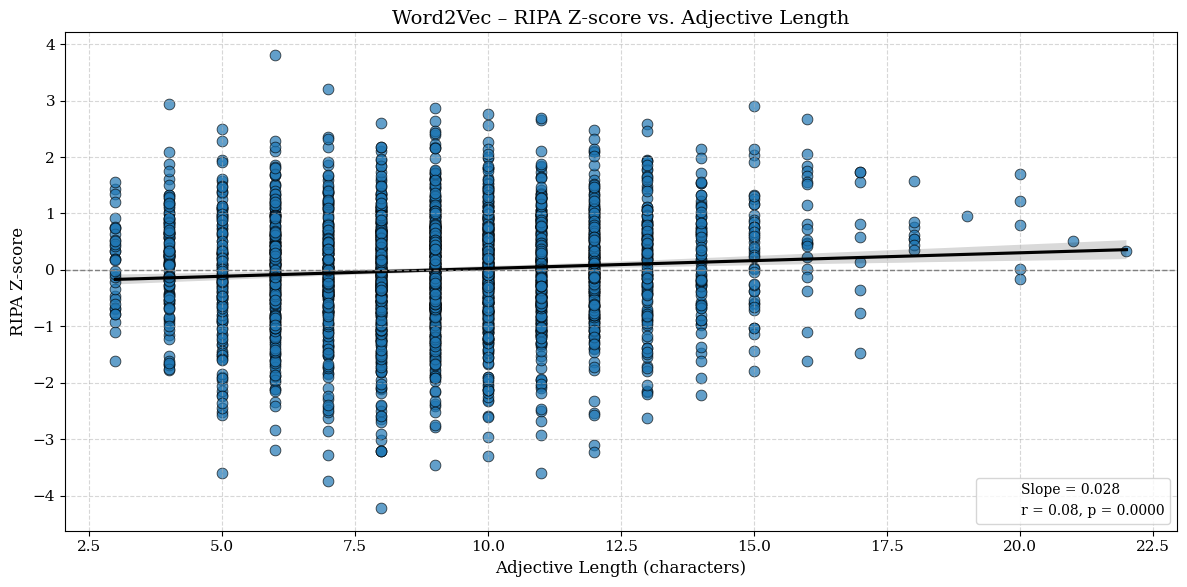

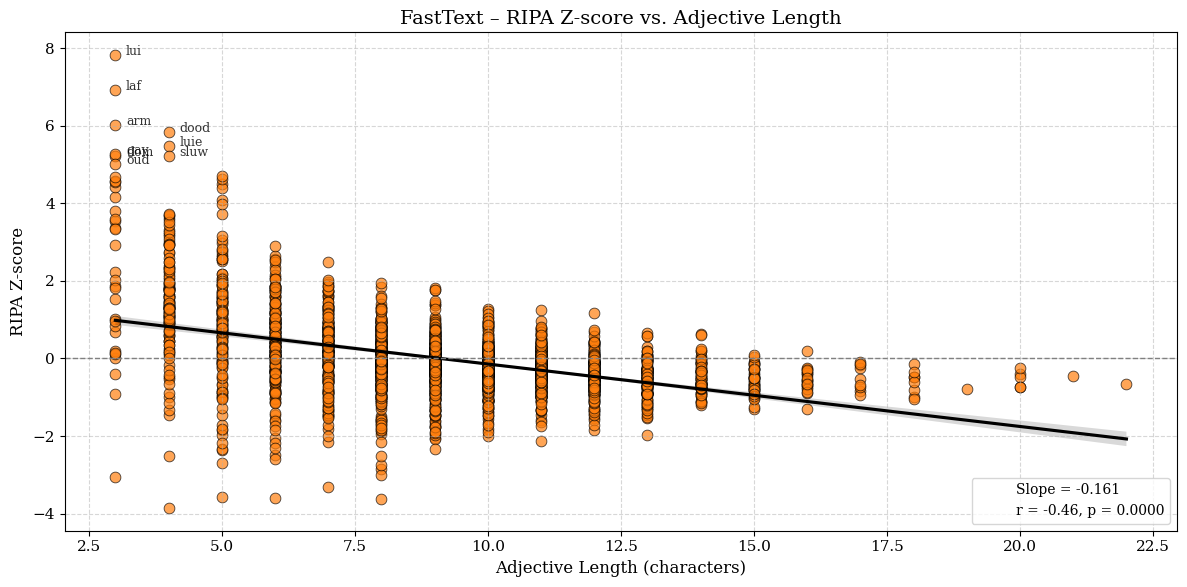

In [27]:
from scipy.stats import linregress

df_combined_w2v['adjective_length'] = df_combined_w2v['word'].str.len()
df_combined_ft['adjective_length'] = df_combined_ft['word'].str.len()

def get_ripa_regression_stats(df):
    slope, intercept, r_value, p_value, _ = linregress(df['adjective_length'], df['ripa_z'])
    return slope, intercept, r_value, p_value

def plot_ripa_vs_length_with_stats(df, model_name, color):
    # Get regression stats
    slope, intercept, r, p = get_ripa_regression_stats(df)
    
    plt.figure(figsize=(12, 6))

    # --- Scatter plot
    sns.scatterplot(
        data=df,
        x='adjective_length',
        y='ripa_z',
        alpha=0.7,
        color=color,
        s=60,
        edgecolor='black'
    )

    # --- Regression line manually
    sns.regplot(
        data=df,
        x='adjective_length',
        y='ripa_z',
        scatter=False,
        color='black'
    )

    # --- Add regression stats to legend
    plt.plot([], [], ' ', label=f"Slope = {slope:.3f}")
    plt.plot([], [], ' ', label=f"r = {r:.2f}, p = {p:.4f}")

    # --- Reference line
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # --- Annotate strong outliers
    outliers = df[df['ripa_z'].abs() > 5]
    for _, row in outliers.iterrows():
        plt.text(
            row['adjective_length'] + 0.2,
            row['ripa_z'],
            row['word'],
            fontsize=9,
            alpha=0.8
        )

    # --- Layout and labels
    plt.title(f"{model_name} – RIPA Z-score vs. Adjective Length", fontsize=14)
    plt.xlabel("Adjective Length (characters)", fontsize=12)
    plt.ylabel("RIPA Z-score", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right', fontsize=10, frameon=True)
    plt.tight_layout()
    plt.show()



plot_ripa_vs_length_with_stats(df_combined_w2v, "Word2Vec", "#1f77b4")
plot_ripa_vs_length_with_stats(df_combined_ft, "FastText", "#ff7f0e")


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare aligned data
X_w2v = df_combined_w2v[['bias']].values
X_ft  = df_combined_ft[['bias']].values
y_w2v = df_combined_w2v['RIPA_score'].values
y_ft  = df_combined_ft['RIPA_score'].values

# Fit models
model_w2v = LinearRegression().fit(X_w2v, y_w2v)
model_ft  = LinearRegression().fit(X_ft, y_ft)

# R² scores
r2_w2v = model_w2v.score(X_w2v, y_w2v)
r2_ft  = model_ft.score(X_ft, y_ft)

print(f"Word2Vec R²:  {r2_w2v:.3f}")
print(f"FastText R²:  {r2_ft:.3f}")



Word2Vec R²:  0.923
FastText R²:  0.357


To assess the consistency of bias detection across embedding models and metrics, we conducted a robustness analysis comparing three different operationalizations of gender bias:

Cosine similarity bias (Word2Vec)
Cosine similarity bias (FastText)
RIPA scores (Word2Vec)
We extracted the top 50 adjectives with the highest absolute bias scores from each method and visualized their overlap using a Venn diagram (see Figure X). This allows us to assess how frequently different methods agree on which adjectives are the most gender-biased.

Key Observations:

The intersection of all three methods identified n = XX adjectives, indicating a moderate level of consensus.
A large portion of the FastText cosine bias words (n = 35) were not found among the most biased terms in either of the Word2Vec-based methods, suggesting model-specific sensitivities.
The overlap between Word2Vec cosine and RIPA was substantially higher (n = 28), indicating strong internal consistency within that model.
This pattern supports our earlier finding that Word2Vec correlates more strongly with RIPA scores (r = 0.96, p < .001) than FastText does (r = 0.54), further reinforcing the idea that Word2Vec provides more stable and interpretable bias signals in this context.

Interpretation:

These results suggest that the choice of embedding model can substantially affect which words are flagged as gender-biased. While RIPA and cosine similarity are both derived from the same semantic space, their different formulations lead to partially overlapping but distinct outcomes.

FastText’s low overlap and weaker correlation with RIPA may be due to:

its reliance on subword-level representations,
overgeneralization in morphologically complex adjectives,
or differences in frequency sensitivity.
Conclusion:

For downstream tasks requiring high-confidence bias detection, relying on consensus across multiple methods — or on more internally consistent models such as Word2Vec — provides a more robust foundation. The Venn analysis highlights both agreement and divergence, offering transparency in bias attribution and helping identify which adjectives consistently carry strong gender connotations across techniques.




Figure X: Venn diagram illustrating the overlap between the top 50 gender-biased adjectives as identified by three methods: cosine similarity in Word2Vec embeddings, cosine similarity in FastText embeddings, and RIPA scores in Word2Vec.
Each circle represents the set of adjectives ranked highest by absolute bias scores in that method. The intersection shows the degree of agreement across models and metrics. Numbers indicate the count and percentage of adjectives that appear in each overlap region.
The central region (n = 11) reflects consensus across all approaches, suggesting robust gender association signals. Non-overlapping regions reveal method-specific biases, especially from FastText, which shows low overlap with both Word2Vec-based measures.

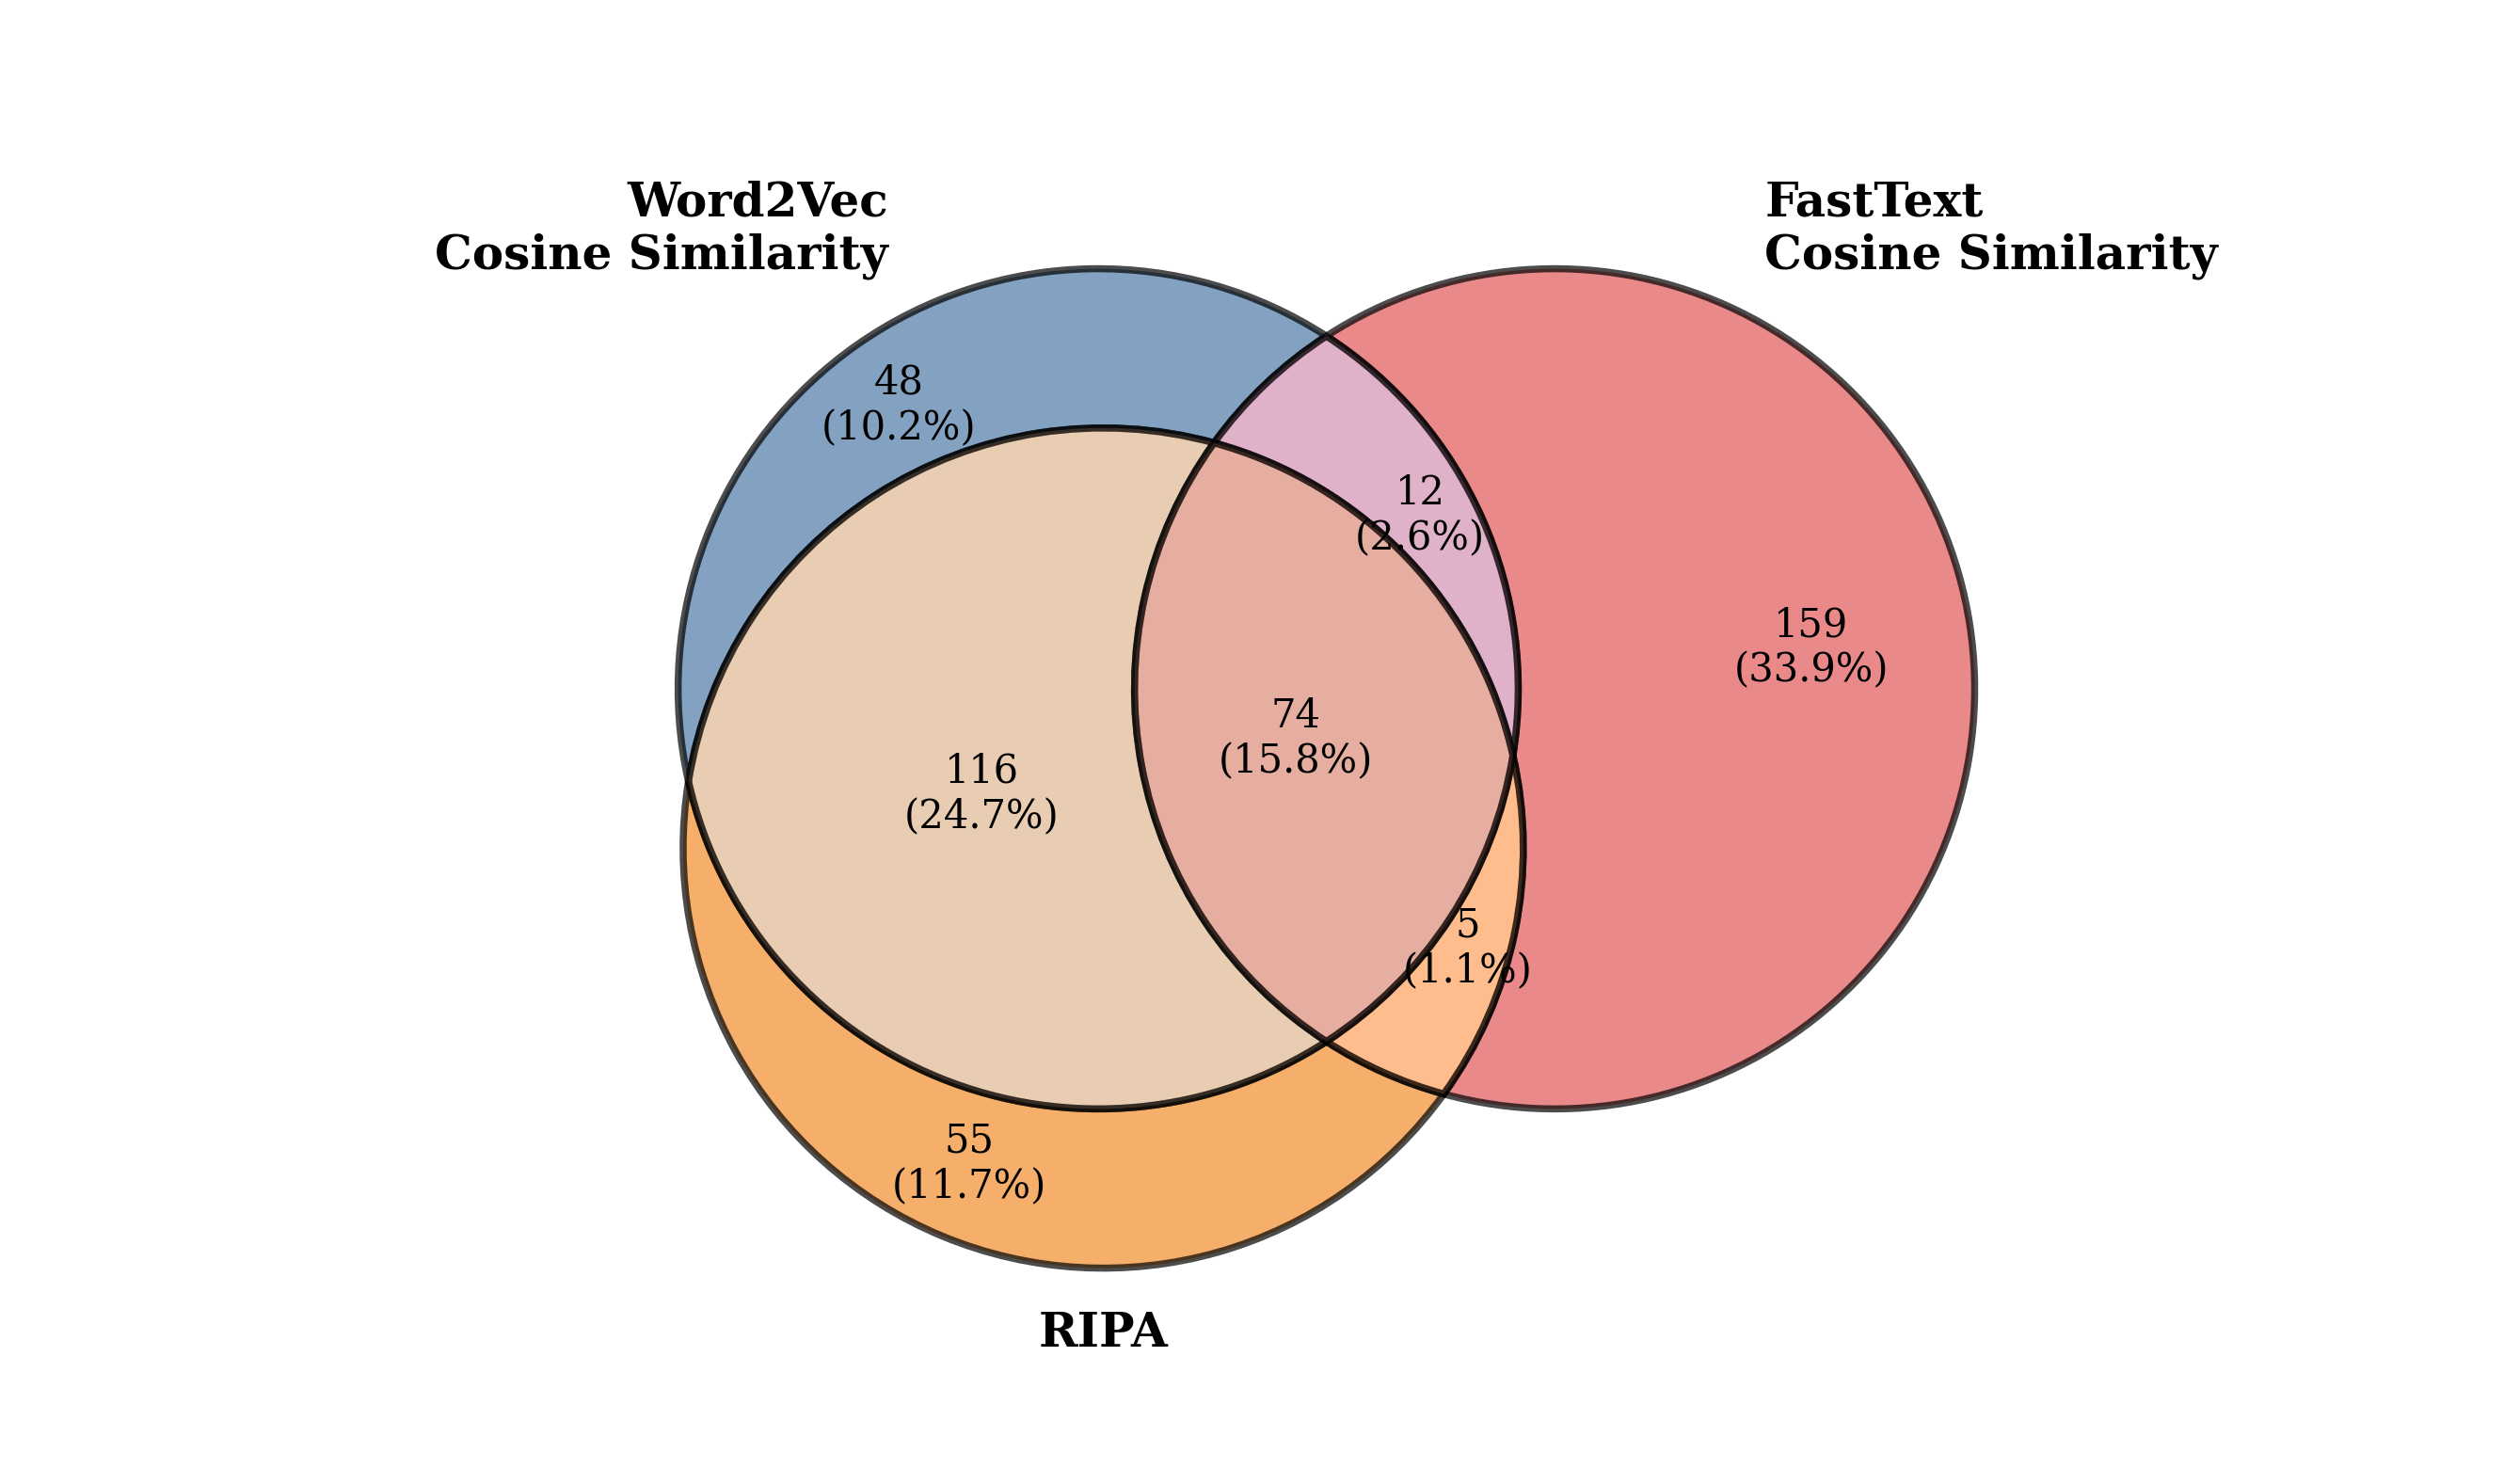

In [29]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.font_manager as fm
import numpy as np

TOP_N = 250

top_cosine_w2v = set(df_combined_w2v.sort_values('cosine_bias_z', key=abs, ascending=False).head(TOP_N)['word'])
top_cosine_ft = set(df_combined_ft.sort_values('cosine_bias_z', key=abs, ascending=False).head(TOP_N)['word'])
top_ripa_w2v = set(df_combined_w2v.sort_values('ripa_z', key=abs, ascending=False).head(TOP_N)['word'])

all_words = top_cosine_w2v | top_cosine_ft | top_ripa_w2v
total_words = len(all_words)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8

fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
venn = venn3(
    [top_cosine_w2v, top_cosine_ft, top_ripa_w2v],
    set_labels=("Word2Vec\nCosine Similarity", "FastText\nCosine Similarity", "RIPA"),
    set_colors=("#4E79A7", "#E15759", "#F28E2B"),
    alpha=0.7,
    ax=ax
)

# Forcefully center diagram within the axis by adjusting limits
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-0.7, 0.7)


# Bold circle edges
for patch in venn.patches:
    if patch:
        patch.set_linewidth(1.8)
        patch.set_edgecolor('black')

# Enhance label visibility and formatting
for text in venn.set_labels:
    if text:
        text.set_fontweight('bold')
        text.set_fontsize(12)

# Add percentages to each region with improved formatting
for subset_id in ['100', '010', '110', '001', '101', '011', '111']:
    subset = venn.get_label_by_id(subset_id)
    if subset:
        count = int(subset.get_text())
        perc = 100 * count / total_words
        subset.set_text(f"{count}\n({perc:.1f}%)")
        subset.set_fontsize(10)

# NOTE: Title and subtitle removed so you can add them manually as requested

# Add figure caption manually later — not in plot
# Optional grid and border
plt.grid(False)
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('gender_bias_venn_diagram.pdf', bbox_inches='tight', dpi=300)
plt.savefig('gender_bias_venn_diagram.png', bbox_inches='tight', dpi=300)

plt.show()


In [30]:
shared_all = top_cosine_w2v & top_cosine_ft & top_ripa_w2v
only_in_ripa = top_ripa_w2v - (top_cosine_w2v | top_cosine_ft)
print(shared_all)
print(only_in_ripa)

{'zwoel', 'modebewust', 'schattig', 'voluptueus', 'flirterig', 'sluw', 'lieftallig', 'fleurig', 'platinablond', 'feministisch', 'crimineel', 'modieus', 'elegant', 'corrupter', 'fanatiek', 'vaginaal', 'superslanke', 'gracieus', 'transseksueel', 'hoogblond', 'levenslustig', 'ongehuwd', 'weelderig', 'goudblond', 'rozig', 'dromerig', 'loyaal', 'lief', 'zedig', 'laffe', 'bloedmooi', 'slank', 'naakt', 'wellustig', 'indisch', 'bloedmooie', 'superslank', 'erotisch', 'verrukkelijk', 'geniaal', 'roodharig', 'overmoedig', 'bekoorlijk', 'ongetrouwd', 'glamoureus', 'halfnaakt', 'alleenstaand', 'aanbiddelijk', 'blond', 'supergezellig', 'lamme', 'sensueel', 'donkerblond', 'beeldschoon', 'zwanger', 'tuttig', 'mollig', 'slanke', 'teder', 'huwelijks', 'zoetig', 'appetijtelijk', 'donkerharig', 'bevallig', 'rimpelig', 'erotische', 'beeldig', 'goudblonde', 'lesbisch', 'spierwit', 'slonzig', 'hangerig', 'huishoudelijk', 'kittig'}
{'geelgroen', 'jeugdig', 'bangig', 'toornig', 'nazistisch', 'fataal', 'pretent

In [38]:
def get_top_gender_biased_words(df, top_n=35, method='combined'):
    """
    Returns top N male- and female-biased adjectives based on both cosine and RIPA z-scores.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['word', 'cosine_bias_z', 'ripa_z']
    top_n : int
        Number of top biased adjectives to return for each gender
    method : str
        Scoring method: 'combined', 'ripa', 'cosine', or 'borda'

    Returns
    -------
    df_male_top : Top N male-biased adjectives
    df_female_top : Top N female-biased adjectives
    """
    df = df.copy()

    if method == 'combined':
        df['score'] = (df['cosine_bias_z'] + df['ripa_z']) / 2

    elif method == 'borda':
        df['rank_cosine'] = df['cosine_bias_z'].rank(ascending=False)
        df['rank_ripa'] = df['ripa_z'].rank(ascending=False)
        df['score'] = df['rank_cosine'] + df['rank_ripa']

    elif method == 'ripa':
        df['score'] = df['ripa_z']

    elif method == 'cosine':
        df['score'] = df['cosine_bias_z']

    else:
        raise ValueError("Method must be 'combined', 'borda', 'ripa', or 'cosine'")

    # Sort by final score (desc → male bias; asc → female bias)
    df_male = df.sort_values('score', ascending=False).head(top_n)
    df_female = df.sort_values('score', ascending=True).head(top_n)

    return df_male[['word', 'cosine_bias_z', 'ripa_z', 'score']], df_female[['word', 'cosine_bias_z', 'ripa_z', 'score']]


male_top_w2v, female_top_w2v = get_top_gender_biased_words(df_combined_w2v, top_n=35, method='combined')

print(f"Top 35 Male-Biased Adjectives (Word2Vec + RIPA):")
print(male_top_w2v)

print("\nTop 35 Female-Biased Adjectives (Word2Vec + RIPA):")
print(female_top_w2v)


Top 35 Male-Biased Adjectives (Word2Vec + RIPA):
                  word  cosine_bias_z    ripa_z     score
6               luther       3.085155  3.808821  3.446988
9              corrupt       3.287878  3.201038  3.244458
60     onoverwinnelijk       2.731618  2.908050  2.819834
88    plaatsvervangend       2.771570  2.675164  2.723367
21          impopulair       2.679160  2.761592  2.720376
184          goddeloos       2.507321  2.877223  2.692272
54         incompetent       2.703911  2.650272  2.677091
45            misdadig       2.681519  2.596465  2.638992
133            bekwaam       2.830790  2.323610  2.577200
132         sadistisch       2.560351  2.575174  2.567763
382        gewetenloos       2.408697  2.690655  2.549676
67           steenrijk       2.455604  2.640475  2.548039
62       vooraanstaand       2.613492  2.469589  2.541540
43       voortvluchtig       2.472851  2.584405  2.528628
22             geniaal       2.624081  2.359347  2.491714
79           planmatig 

In [39]:
male_top_w2v['word'].to_csv("top_male_biased_adjectives_w2v.csv", index=False, header=False)
female_top_w2v['word'].to_csv("top_female_biased_adjectives_w2v.csv", index=False, header=False)

print("Saved to:")
print("top_male_biased_adjectives_w2v.csv")
print("top_female_biased_adjectives_w2v.csv")


Saved to:
top_male_biased_adjectives_w2v.csv
top_female_biased_adjectives_w2v.csv


In [33]:
##################################################
# 3) Define the ML-EAT functions
##################################################
def compute_association(w: np.ndarray, A: np.ndarray) -> float:
    """
    Computes the average cosine similarity between a single vector w
    and all vectors in the set A.
    """
    return np.mean([cosine_similarity(w, a) for a in A])

def compute_attribute_association(X: np.ndarray, A: np.ndarray) -> np.ndarray:
    """
    For each vector x in X, compute the average similarity with vectors in A.
    Returns a 1D array of association scores.
    """
    return np.array([compute_association(x, A) for x in X])

def compute_attribute_association_L2(A: np.ndarray, T: np.ndarray) -> np.ndarray:
    """
    For each vector a in A, compute the average similarity with vectors in T.
    Returns a 1D array of association scores.
    """
    return np.array([compute_association(a, T) for a in A])

def compute_joint_std(X_Associations: np.ndarray, Y_Associations: np.ndarray) -> float:
    """
    Computes the pooled standard deviation of the two sets of associations.
    """
    return np.std(np.concatenate([X_Associations, Y_Associations]), ddof=1)

def compute_p_value(X_Diff: np.ndarray,
                    Y_Diff: np.ndarray,
                    permutations: int = 1000) -> float:
    """
    Uses a permutation test (randomly shuffling the X and Y labels)
    to estimate the p-value of the observed difference in sums.
    """
    # Observed difference in sums
    test_statistic = np.sum(X_Diff) - np.sum(Y_Diff)

    # Generate the empirical distribution via permutations
    combined = np.concatenate([X_Diff, Y_Diff])
    empirical_distribution = np.array([
        np.random.choice(combined,
                         size=len(X_Diff) + len(Y_Diff),
                         replace=False)
        for _ in range(permutations)
    ])

    # For each permutation, split back into "X-like" vs. "Y-like" slices
    empirical_differences = (
        np.sum(empirical_distribution[:, :len(X_Diff)], axis=1)
        - np.sum(empirical_distribution[:, len(X_Diff):], axis=1)
    )

    # Compare observed statistic to empirical distribution
    return 1 - norm.cdf(
        test_statistic,
        loc=np.mean(empirical_differences),
        scale=np.std(empirical_differences, ddof=1)
    )

def level_1(X: np.ndarray,
            Y: np.ndarray,
            A: np.ndarray,
            B: np.ndarray,
            permutations: int = 1000) -> tuple[float, float]:
    """
    Level 1 test: Compare differences in association with A vs. B
    for groups X and Y, then compute an effect size and p-value.
    """
    # For group X
    X_Associations_A = compute_attribute_association(X, A)
    X_Associations_B = compute_attribute_association(X, B)
    X_Differential_Associations = X_Associations_A - X_Associations_B

    # For group Y
    Y_Associations_A = compute_attribute_association(Y, A)
    Y_Associations_B = compute_attribute_association(Y, B)
    Y_Differential_Associations = Y_Associations_A - Y_Associations_B

    # Mean difference
    X_Mean = np.mean(X_Differential_Associations)
    Y_Mean = np.mean(Y_Differential_Associations)

    # Permutation-based p-value
    p_value = compute_p_value(X_Differential_Associations,
                              Y_Differential_Associations,
                              permutations=permutations)

    # Effect size: difference in means, normalized by joint std
    effect_size = (
        (X_Mean - Y_Mean)
        / compute_joint_std(X_Differential_Associations, Y_Differential_Associations)
    )
    return effect_size, p_value

def level_2(T: np.ndarray,
            A: np.ndarray,
            B: np.ndarray,
            permutations: int = 1000) -> tuple[float, float]:
    """
    Level 2 test: For the group T, compare associations with A vs. B,
    returning an effect size and p-value.
    """
    A_Associations_T = compute_attribute_association_L2(A, T)
    B_Associations_T = compute_attribute_association_L2(B, T)

    p_value = compute_p_value(A_Associations_T,
                              B_Associations_T,
                              permutations=permutations)

    effect_size = (
        (np.mean(A_Associations_T) - np.mean(B_Associations_T))
        / compute_joint_std(A_Associations_T, B_Associations_T)
    )
    return effect_size, p_value

def level_3(T: np.ndarray, A: np.ndarray) -> tuple[float, float]:
    """
    Level 3 test: For the group T, measure the overall average similarity to A
    (and its standard deviation).
    """
    T_Associations_A = [cosine_similarity(t, a) for t in T for a in A]
    return np.mean(T_Associations_A), np.std(T_Associations_A, ddof=1)

def ML_EAT(A: np.ndarray,
           B: np.ndarray,
           X: np.ndarray,
           Y: np.ndarray,
           permutations: int = 1000) -> dict:
    """
    Consolidates the Level 1, Level 2, and Level 3 ML-EAT metrics into one dict.
    X, Y = two target groups you want to compare (e.g. male-coded vs. female-coded words)
    A, B = two attribute sets (e.g. pleasant vs. unpleasant terms)
    """
    # --- Level 1
    L1_effect_size, L1_p_value = level_1(X, Y, A, B, permutations=permutations)

    # --- Level 2
    L2_effect_size_X, L2_p_value_X = level_2(X, A, B, permutations=permutations)
    L2_effect_size_Y, L2_p_value_Y = level_2(Y, A, B, permutations=permutations)

    # --- Level 3
    L3_mean_AX, L3_std_AX = level_3(X, A)
    L3_mean_BX, L3_std_BX = level_3(X, B)
    L3_mean_AY, L3_std_AY = level_3(Y, A)
    L3_mean_BY, L3_std_BY = level_3(Y, B)

    return {
        'L1_effect_size': L1_effect_size,
        'L1_p_value': L1_p_value,

        'L2_effect_size_X': L2_effect_size_X,
        'L2_p_value_X': L2_p_value_X,
        'L2_effect_size_Y': L2_effect_size_Y,
        'L2_p_value_Y': L2_p_value_Y,

        'L3_mean_AX': L3_mean_AX,
        'L3_std_AX': L3_std_AX,
        'L3_mean_BX': L3_mean_BX,
        'L3_std_BX': L3_std_BX,
        'L3_mean_AY': L3_mean_AY,
        'L3_std_AY': L3_std_AY,
        'L3_mean_BY': L3_mean_BY,
        'L3_std_BY': L3_std_BY,
    }

##################################################
# 4) Optional: Utility to fetch embeddings by word index
##################################################
def get_np_embeddings(
    target_words: list,
    vocab_dict: dict,
    embeddings: np.ndarray
) -> np.ndarray:
    """
    Given a list of words, a vocab->index dict, and the raw embedding matrix,
    returns an array of shape (len(target_words), embedding_dim).
    """
    return np.array([embeddings[vocab_dict[word]] for word in target_words])


In [34]:
################################################################################
# Convert male, female, and the single set of adjectives to NumPy arrays
################################################################################

# We already have:
MALE_WORDS = ["man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom"]
FEMALE_WORDS = ["vrouw", "dame", "meisje", "moeder", "dochter", "meid", "mevrouw", "oma","tante"]

# Single set of adjectives (the big list of 2741 items after filtering)
# from "filtered_adjectives"
adjective_list = list(filtered_adjectives)

# Now, fetch vectors from your Word2Vec KeyedVectors (model_w2v)
male_vecs = np.array([w2v_model[w] for w in MALE_WORDS if w in w2v_model])
female_vecs = np.array([w2v_model[w] for w in FEMALE_WORDS if w in w2v_model])
adjective_vecs = np.array([w2v_model[w] for w in adjective_list if w in w2v_model])

print("Shapes:")
print("male_vecs:", male_vecs.shape)
print("female_vecs:", female_vecs.shape)
print("adjective_vecs:", adjective_vecs.shape)

################################################################################
#  Use level_3(...) on each target group vs. your single attribute set
################################################################################

mean_male, std_male = level_3(male_vecs, adjective_vecs)
mean_female, std_female = level_3(female_vecs, adjective_vecs)

print("=== Level 3 with a single attribute set of adjectives ===")
print(f"Male-coded -> Adjectives: mean={mean_male:.3f}, std={std_male:.3f}")
print(f"Female-coded -> Adjectives: mean={mean_female:.3f}, std={std_female:.3f}")

# After you've computed these:
# mean_male, std_male = level_3(male_vecs, adjective_vecs)
# mean_female, std_female = level_3(female_vecs, adjective_vecs)

Shapes:
male_vecs: (10, 320)
female_vecs: (9, 320)
adjective_vecs: (2641, 320)
=== Level 3 with a single attribute set of adjectives ===
Male-coded -> Adjectives: mean=0.262, std=0.094
Female-coded -> Adjectives: mean=0.264, std=0.097


Male-coded full set has shape: (10, 320)
Female-coded full set has shape: (9, 320)
Adjective set has shape: (2641, 320)


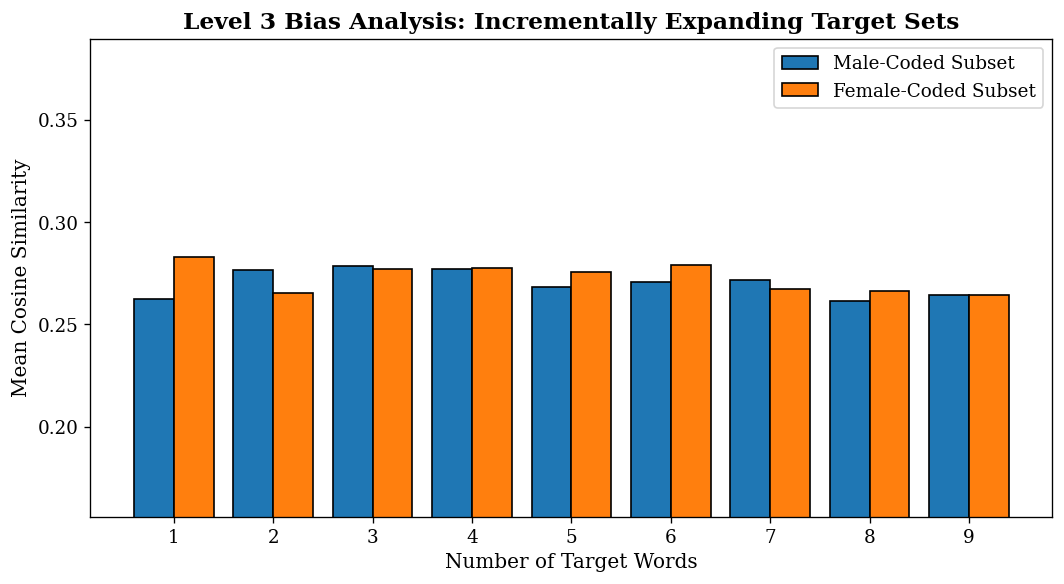

In [35]:
###############################################################################
# 2) CONVERT THE MALE & FEMALE WORD LISTS INTO EMBEDDING MATRICES, PRESERVING ORDER
###############################################################################
male_coded_vecs = []
for w in MALE_WORDS:
    if w in w2v_model:
        male_coded_vecs.append(w2v_model[w])
male_coded_vecs = np.array(male_coded_vecs)

female_coded_vecs = []
for w in FEMALE_WORDS:
    if w in w2v_model:
        female_coded_vecs.append(w2v_model[w])
female_coded_vecs = np.array(female_coded_vecs)

print(f"Male-coded full set has shape: {male_coded_vecs.shape}")
print(f"Female-coded full set has shape: {female_coded_vecs.shape}")
print(f"Adjective set has shape: {adjective_vecs.shape}")

###############################################################################
# 3) EXPAND FROM LEFT TO RIGHT:
#    - For subset size = 1, use only the first word in each list.
#    - For subset size = 2, use the first two words, etc.
###############################################################################
max_len = min(len(male_coded_vecs), len(female_coded_vecs))
subset_sizes = range(1, max_len + 1)

male_means, male_stds = [], []
female_means, female_stds = [], []

for size in subset_sizes:
    # Subset the first 'size' male-coded embeddings
    male_subset = male_coded_vecs[:size]
    mean_male, std_male = level_3(male_subset, adjective_vecs)
    male_means.append(mean_male)
    male_stds.append(std_male)

    # Subset the first 'size' female-coded embeddings
    female_subset = female_coded_vecs[:size]
    mean_female, std_female = level_3(female_subset, adjective_vecs)
    female_means.append(mean_female)
    female_stds.append(std_female)

male_means = np.array(male_means)
male_stds = np.array(male_stds)
female_means = np.array(female_means)
female_stds = np.array(female_stds)

###############################################################################
# 5) PLOT SIDE-BY-SIDE BARS WITH ERROR BARS (MEAN ± 1 STD), ZOOMED-IN Y-AXIS
###############################################################################
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)

x_positions = np.arange(len(subset_sizes))
bar_width = 0.4

# Plot male-coded bars
ax.bar(
    x_positions - bar_width/2,
    male_means,
    width=bar_width,
    edgecolor='black',
    label="Male-Coded Subset",
    color="#1f77b4"
)

# Plot female-coded bars
ax.bar(
    x_positions + bar_width/2,
    female_means,
    width=bar_width,  
    edgecolor='black',
    label="Female-Coded Subset",
    color="#ff7f0e"
)

# X-axis
ax.set_xticks(x_positions)
ax.set_xticklabels([str(s) for s in subset_sizes])
ax.set_xlabel("Number of Target Words", fontsize=12)

# Y-axis
ax.set_ylabel("Mean Cosine Similarity", fontsize=12)

# Optional: narrow the y-axis range to 'zoom in' if your data is in [0.22, 0.28] etc.
all_means = np.concatenate([male_means, female_means])
all_stds = np.concatenate([male_stds, female_stds])
y_min = np.min(all_means - all_stds) - 0.01
y_max = np.max(all_means + all_stds) + 0.01
ax.set_ylim(y_min, y_max)

# Title & legend
ax.set_title("Level 3 Bias Analysis: Incrementally Expanding Target Sets", 
             fontsize=14, fontweight='bold')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

In [36]:
## LEAVE ONE APPROACH (INSTEAD OF TRUNCATING I COULD LEAVE ONE OUT, TO SHOW MARGINAL EFFECTS)
## COMPARE LLMS WHICH ARE FINED TUNED FOR CHAT (IF THEY ARE EVEN MORE BIASED?); VERSUS PURE LANGUAGE MODELS. 
    ### LANGUAGE MODEL (EFFECT OF RL FINE TUNING): 
        llama-2-uncensored
        llama-2-chat
        PARAMETERS: 
            temperature
            
    ### CHAT MODELS: {DISTILLED MODELS}

IndentationError: unexpected indent (3898831901.py, line 4)